In [83]:
#Referencing https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb

import requests
from bs4 import BeautifulSoup

import pandas as pd

import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import yfinance as yf
import pandas_datareader as pdr

### $Return_{t_1, t_2} = \frac{Price_{t_2}}{Price_{t_1}} - 1$
### $PriceToSales_{t_1} = \frac{Price_{t_1}}{SalesPerShare_{t_1}}$
### $Return_{t_1, t_2} = \frac{PriceToSales_{t_2}SalesPerShareGrowth_{t_1, t_2}}{PriceToSales_{t_1}} - 1$

In [84]:
df_sp500_uncleaned = yf.Ticker("^GSPC").history(period='max')

In [85]:
def clean_df(df):
    df.index.name = None
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq='D')).interpolate()

    SP500_Sales_Per_Share = pd.read_csv('data/S&P 500 Sales Per Share.csv')
    SP500_Sales_Per_Share.index = pd.to_datetime(SP500_Sales_Per_Share['Date\tSales Per Share'].str[:10], format='%m/%d/%Y')
    SP500_Sales_Per_Share.index.name = None
    SP500_Sales_Per_Share = SP500_Sales_Per_Share.rename(columns={'Date\tSales Per Share': 'Sales Per Share'})
    SP500_Sales_Per_Share['Sales Per Share'] = SP500_Sales_Per_Share['Sales Per Share'].str[11:].astype('float')
    SP500_Sales_Per_Share = SP500_Sales_Per_Share.sort_index()
    SP500_Sales_Per_Share = SP500_Sales_Per_Share.reindex(pd.date_range(SP500_Sales_Per_Share.index[0], SP500_Sales_Per_Share.index[-1], freq='D')).interpolate()

    df = pd.merge(df['Close'].to_frame(), SP500_Sales_Per_Share, how='inner', left_index=True, right_index=True)
    df = df.rename(columns={'Close': 'Price'})
    df['Price to Sales'] = df['Price'] / df['Sales Per Share']
    df['Price to Sales TM'] = df['Price to Sales'].expanding().mean()

    return df
df_sp500 = clean_df(df_sp500_uncleaned)

In [86]:
def add_pred(df, days):
    someConst = df['Price to Sales TM'] * (df['Sales Per Share'] / df['Sales Per Share'].shift(days)).expanding().mean()
    df[str(days) + '- Pred'] = ((someConst / df['Price to Sales'])*df_sp500['Price']).shift(days)

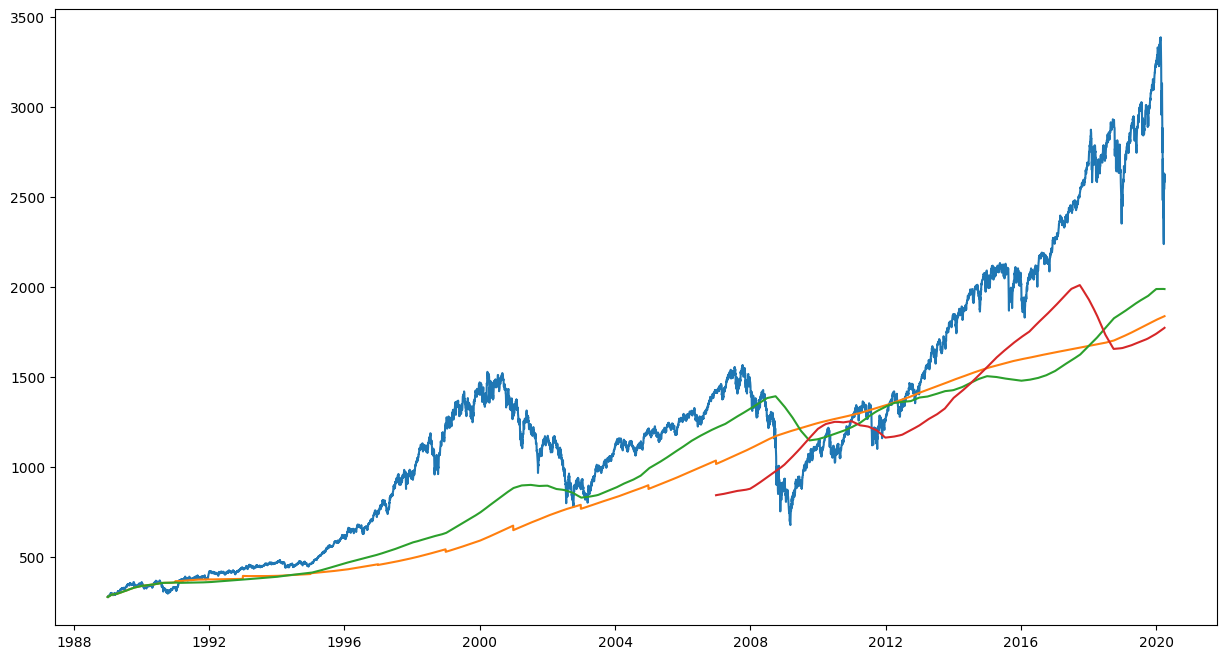

In [113]:
plt.figure(figsize=(15, 8))
plt.plot(df_sp500['Price'])

for i in range(10):
    days = i * 365
    add_pred(df_sp500, days)
df_sp500['avg- Pred'] = df_sp500[df_sp500.columns[df_sp500.columns.to_series().str.find('Pred') > 0]].mean(axis=1)

plt.plot(df_sp500['avg- Pred'])
plt.plot(df_sp500['0- Pred'])
plt.plot(df_sp500['3285- Pred'])

plt.show()